In [132]:
from src.data_preprocessing import *
import pandas as pd
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
import seaborn as sns

In [133]:
# Reading raw data file
df_raw = pd.read_csv('../data/heart_disease_data.csv', header=0)

df = df_raw.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB


In [134]:
missing_values = df.isnull().sum()

# Filter out columns that have no missing values
missing_values = missing_values[missing_values > 0]

# Display missing values sorted
missing_values_sorted = missing_values.sort_values(ascending=False)
print("\nColumns with missing values sorted by count:")
print(missing_values_sorted)


Columns with missing values sorted by count:
ca          611
thal        486
slope       309
fbs          90
oldpeak      62
trestbps     59
thalch       55
exang        55
chol         30
restecg       2
dtype: int64


In [135]:
# Separate numerical and categorical columns
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = df.select_dtypes(include=['object']).columns

In [136]:
# Impute numerical data using Iterative Imputer
numerical_imputer = IterativeImputer(random_state=0)
df[numerical_columns] = numerical_imputer.fit_transform(df[numerical_columns])

In [137]:
# Encode categorical data
label_encoders = {}
for col in categorical_columns:
    label_encoders[col] = LabelEncoder()
    df[col] = label_encoders[col].fit_transform(df[col].astype(str))

In [138]:
# Impute categorical data using Random Forest
rf_imputer = SimpleImputer(strategy='most_frequent')
df[categorical_columns] = rf_imputer.fit_transform(df[categorical_columns])

In [139]:
# Create a Random Forest Classifier for each categorical column
rf_imputers = {}
for col in categorical_columns:
    rf_imputers[col] = RandomForestClassifier(n_estimators=100, random_state=0)
    
    # Prepare the data for the Random Forest
    X = df.drop(col, axis=1)
    y = df[col]
    
    # Fit the Random Forest
    rf_imputers[col].fit(X[y.notnull()], y[y.notnull()])
    
    # Impute missing values
    missing_indices = y.isnull()
    if missing_indices.sum() > 0:
        imputed_values = rf_imputers[col].predict(X[missing_indices])
        df.loc[missing_indices, col] = imputed_values

In [140]:
# Print the first few rows of the preprocessed data
print(df.head())

# Check for any remaining missing values
print(df.isnull().sum())

    id   age  sex  dataset  cp  trestbps   chol  fbs  restecg  thalch  exang  \
0  1.0  63.0    1        0   3     145.0  233.0    1        0   150.0      0   
1  2.0  67.0    1        0   0     160.0  286.0    0        0   108.0      1   
2  3.0  67.0    1        0   0     120.0  229.0    0        0   129.0      1   
3  4.0  37.0    1        0   2     130.0  250.0    0        2   187.0      0   
4  5.0  41.0    0        0   1     130.0  204.0    0        0   172.0      0   

   oldpeak  slope   ca  thal  num  
0      2.3      0  0.0     0  0.0  
1      1.5      1  3.0     2  2.0  
2      2.6      1  2.0     3  1.0  
3      3.5      0  0.0     2  0.0  
4      1.4      3  0.0     2  0.0  
id          0
age         0
sex         0
dataset     0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalch      0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
num         0
dtype: int64


In [141]:
# Creating a function to plot boxplots for numerical columns
def plot_boxplots(df, columns, n_cols=3):
    n_rows = (len(columns) - 1) // n_cols + 1
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows))
    axes = axes.flatten()
    
    for i, col in enumerate(columns):
        sns.boxplot(x=df[col], ax=axes[i])
        axes[i].set_title(col)
        axes[i].set_xlabel('')
    
    for j in range(i+1, len(axes)):
        axes[j].remove()
    
    plt.tight_layout()
    plt.show()

# Removing outliers
def remove_outliers(df, columns, factor=1.5):
    df_clean = df.copy()
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    return df_clean

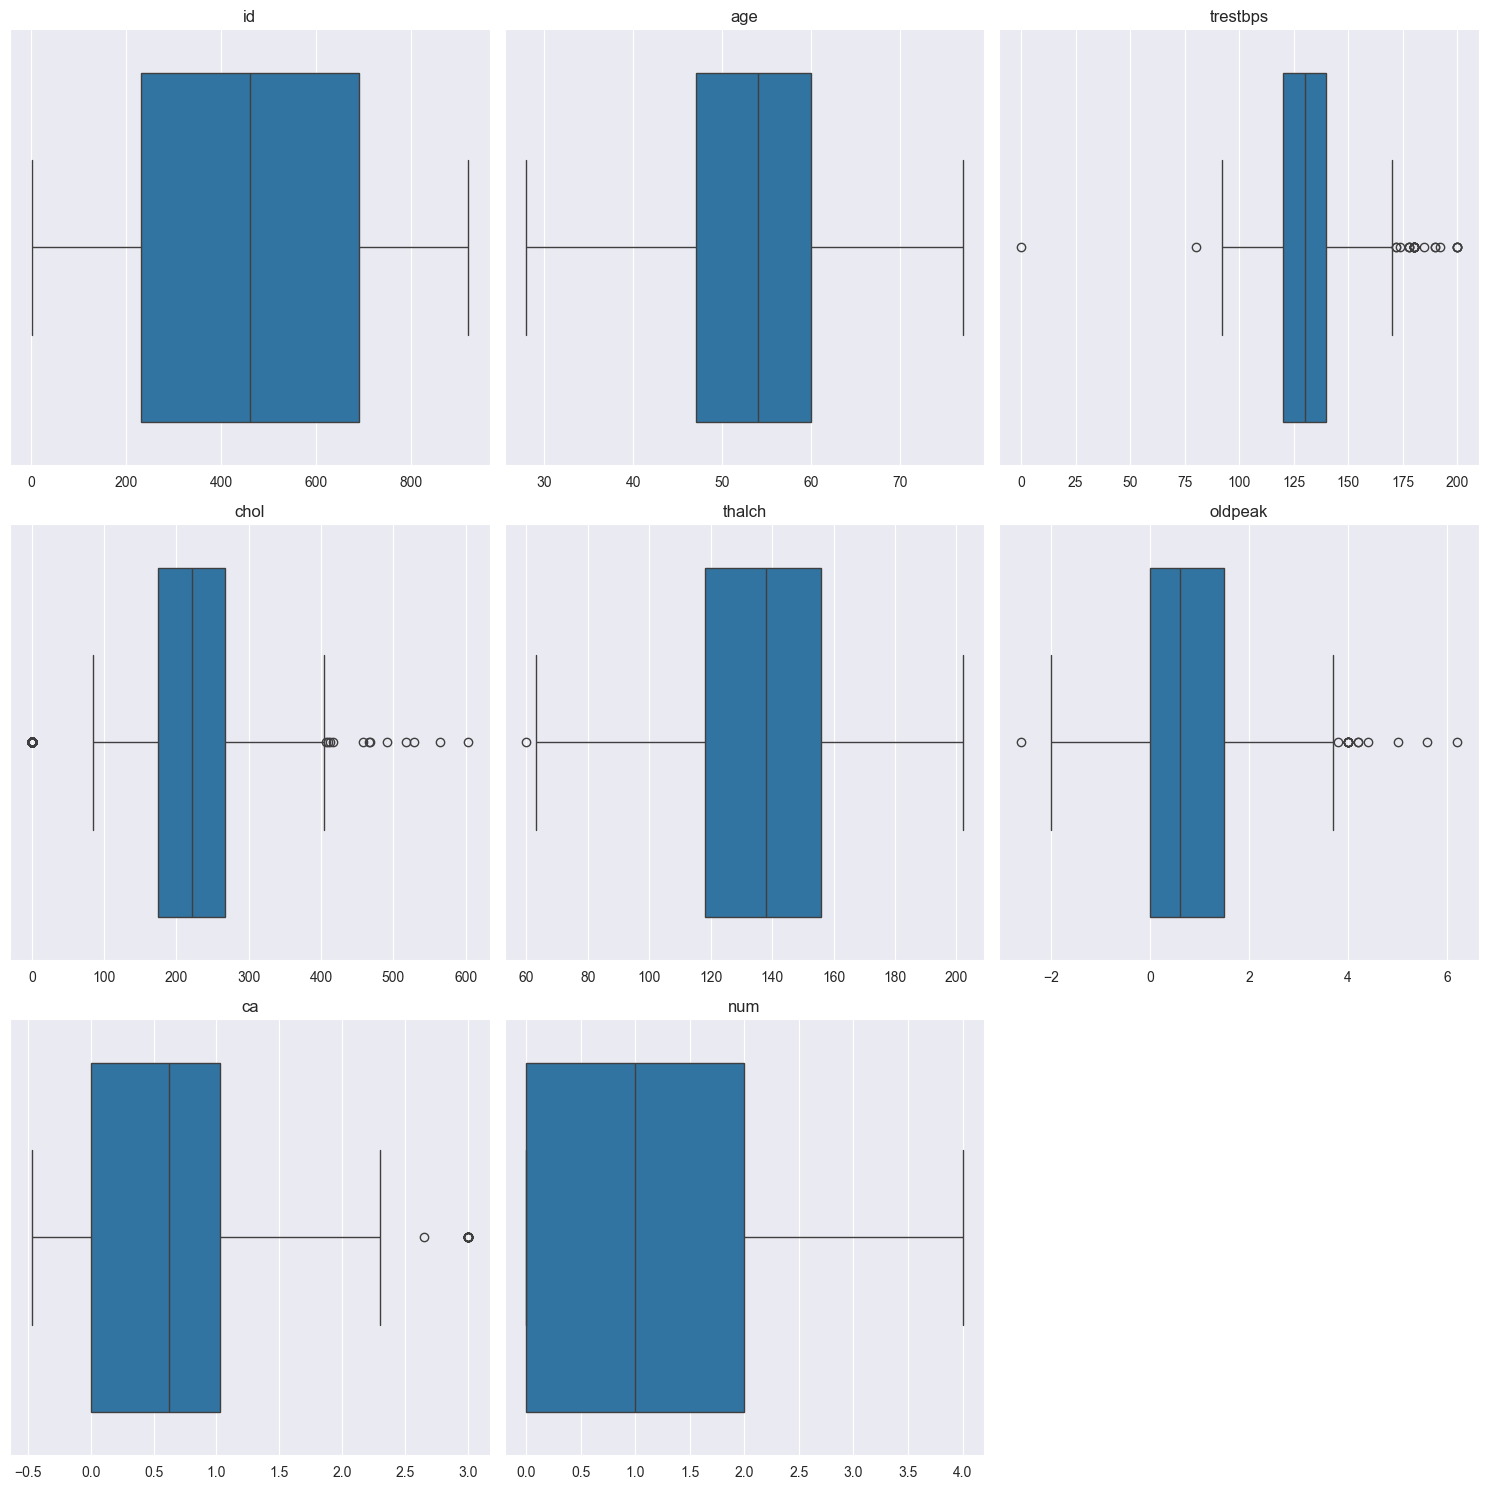

In [142]:
plot_boxplots(df, numerical_columns)

In [144]:
print("trestbps statistics:")
print(df['trestbps'].describe())

print("\nNumber of negative trestbps values:")
print((df['trestbps'] == 0).sum())

print("\nNegative trestbps values:")
print(df[df['trestbps'] == 0]['trestbps'])

# Removal of any rows with a trestbps value of zero
df = df[df['trestbps'] != 0]

trestbps statistics:
count    920.000000
mean     132.406419
std       18.516892
min        0.000000
25%      120.000000
50%      130.000000
75%      140.000000
max      200.000000
Name: trestbps, dtype: float64

Number of negative trestbps values:
1

Negative trestbps values:
753    0.0
Name: trestbps, dtype: float64


In [145]:
print("chol statistics:")
print(df['chol'].describe())

print("\nNumber of negative chol values:")
print((df['chol'] == 0).sum())

print("\nNegative chol values:")
print(df[df['chol'] == 0]['chol'])

# Removal of any rows with a chol value of zero
df = df[df['chol'] != 0]

chol statistics:
count    919.000000
mean     199.010658
std      109.015820
min        0.000000
25%      175.009775
50%      222.000000
75%      267.000000
max      603.000000
Name: chol, dtype: float64

Number of negative chol values:
171

Negative chol values:
597    0.0
598    0.0
599    0.0
600    0.0
601    0.0
      ... 
818    0.0
819    0.0
822    0.0
839    0.0
840    0.0
Name: chol, Length: 171, dtype: float64


In [146]:
print("Oldpeak statistics:")
print(df['oldpeak'].describe())

print("\nNumber of negative oldpeak values:")
print((df['oldpeak'] < 0).sum())

print("\nNegative oldpeak values:")
print(df[df['oldpeak'] < 0]['oldpeak'])

# Removal of any rows with a oldpeak value less than zero
df = df[df['oldpeak'] > 0]

Oldpeak statistics:
count    748.000000
mean       0.905749
std        1.071895
min        0.000000
25%        0.000000
50%        0.521441
75%        1.500000
max        6.200000
Name: oldpeak, dtype: float64

Number of negative oldpeak values:
0

Negative oldpeak values:
Series([], Name: oldpeak, dtype: float64)


In [153]:
df.to_csv('../data/hd_data_preprocessed.csv', index=False)
print("Processed data saved to '../data/hd_data_preprocessed.csv'")

Processed data saved to '../data/heart_disease_data_preprocessed.csv'


In [154]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 429 entries, 0 to 918
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        429 non-null    float64
 1   age       429 non-null    float64
 2   sex       429 non-null    int64  
 3   dataset   429 non-null    int64  
 4   cp        429 non-null    int64  
 5   trestbps  429 non-null    float64
 6   chol      429 non-null    float64
 7   fbs       429 non-null    int64  
 8   restecg   429 non-null    int64  
 9   thalch    429 non-null    float64
 10  exang     429 non-null    int64  
 11  oldpeak   429 non-null    float64
 12  slope     429 non-null    int64  
 13  ca        429 non-null    float64
 14  thal      429 non-null    int64  
 15  num       429 non-null    float64
dtypes: float64(8), int64(8)
memory usage: 57.0 KB
